In [1]:
import sklearn
import io
import re
import math
import zipfile
import os
import pandas as pd
import gc
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_to_zip_file = '/content/drive/My Drive/ngwl-predict-customer-churn.zip'
directory_to_extract_to = '/content/drive/My Drive'

In [4]:
#заджойнить все файлы в директории
def get_data_from_path(DIRECTORY):
    data = pd.DataFrame()
    for root,dirs,files in os.walk(DIRECTORY):
      for file in files:
        if file.endswith(".csv"):
            FILENAME = os.path.join(DIRECTORY, file)
            if len(data)==0:
                data = pd.read_csv(FILENAME).drop_duplicates()
                all_data = data.copy()
            else:
                data = pd.read_csv(FILENAME).drop_duplicates()
                all_data = all_data.append(data)
            # print(len(data), len(all_data))

    return all_data.reset_index(drop=True)

In [6]:
TRAIN_FILEPATH = os.path.join(directory_to_extract_to, 'train', 'train.csv')
TEST_FILEPATH = os.path.join(directory_to_extract_to, 'sample_submission.csv')
SHIPMENTS_FILEPATH = os.path.join(directory_to_extract_to, 'shipments')
ADDRESSES_FILEPATH = os.path.join(directory_to_extract_to, 'misc', 'addresses.csv')
CATEGORIES_FILEPATH = os.path.join(directory_to_extract_to, 'misc', 'master_categories.csv')
PROFILES_FILEPATH = os.path.join(directory_to_extract_to, 'misc', 'user_profiles.csv')
ACTIONS_FILEPATH = os.path.join(directory_to_extract_to, 'messages', 'actions.csv')
MESSAGES_FILEPATH = os.path.join(directory_to_extract_to, 'messages', 'messages.csv')

## Чтение данных

In [63]:
train = pd.read_csv(TRAIN_FILEPATH).drop_duplicates()
test = pd.read_csv(TEST_FILEPATH, sep=';')

In [ ]:
shipments = get_data_from_path(SHIPMENTS_FILEPATH)

In [ ]:
shipments['order_month'] = shipments['order_completed_at'].apply(lambda x: x[:7])

In [8]:
shipments.to_csv(os.path.join(directory_to_extract_to, 'shipments.csv'), header=True, index=False)

In [14]:
# shipments = pd.read_csv(os.path.join(directory_to_extract_to, 'shipments.csv'))

In [12]:
addresses = pd.read_csv(ADDRESSES_FILEPATH).drop_duplicates()
# actions = pd.read_csv(ACTIONS_FILEPATH).drop_duplicates()
user_profiles = pd.read_csv(PROFILES_FILEPATH).drop_duplicates()

In [ ]:
## считываем предобработанные данные на основа messages, actions

In [ ]:
actions_prep = pd.read_csv(os.path.join(directory_to_extract_to, 'clean_user_actions.gz'), compression='gzip', header=0, error_bad_lines=False)

In [ ]:
actions_prep['order_month'] = actions_prep.sent.apply(lambda x: str(datetime.utcfromtimestamp(x).strftime('%Y-%m')))

In [ ]:
actions_prep = actions_prep.drop(['sent'], axis=1)

In [ ]:
actions_prep['is_push'] = (actions_prep['type']=='push').astype('int')
actions_prep['is_email'] = (actions_prep['type']=='email').astype('int')
actions_prep['is_sms'] = (actions_prep['type']=='sms').astype('int')

actions_prep['is_bonus'] = (actions_prep['cat']=='bonus').astype('int')
actions_prep['is_hidden'] = (actions_prep['cat']=='hidden').astype('int')
actions_prep['is_info'] = (actions_prep['cat']=='info').astype('int')
actions_prep['is_misc'] = (actions_prep['cat']=='misc').astype('int')
actions_prep['is_new_shops_info'] = (actions_prep['cat']=='new_shops_info').astype('int')
actions_prep['is_promocode'] = (actions_prep['cat']=='promocode').astype('int')
actions_prep['is_sale'] = (actions_prep['cat']=='sale').astype('int')

In [ ]:
actions_prep.to_csv(os.path.join(directory_to_extract_to, 'actions_clean.csv'), header=True, index=False)

In [ ]:
# actions_prep = pd.read_csv(os.path.join(directory_to_extract_to, 'actions_clean.csv'))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# messages = pd.read_csv(MESSAGES_FILEPATH).drop_duplicates()

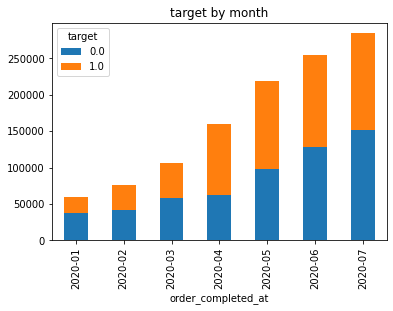

In [ ]:
count_by_date_tv = train.groupby([pd.Grouper(key='order_completed_at'), 'target']).phone_id.count()

count_by_date_tv.unstack(level=1).plot.bar(stacked=True, title='target by month')

In [ ]:
count_by_date_tv.to_excel('/content/drive/My Drive/target.xlsx')

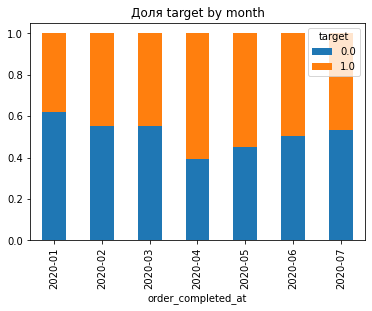

In [ ]:
count_by_date = train.groupby([pd.Grouper(key='order_completed_at')]).phone_id.count()

count_by_date_tv.unstack(level=1).div(count_by_date, axis=0).plot.bar(stacked=True, title='Доля target by month')

## Агрегация и фичи

джойним в соответствии со структурой данных, делаем агрегаты для пары значений `phone_id`, `order_month`

In [ ]:
def aggregate_preprocess(df, shipments=shipments, addresses=addresses, actions=actions_prep, test=False):

    if test:
        df = df.copy().drop(['Predicted'], axis=1)
        step_1 = df.merge(addresses, how='left', left_on='Id', right_on='phone_id').merge(shipments[shipments.order_month=='2020-08'], how='left', left_on='id', right_on='ship_address_id')
    else:
        step_1 = df.merge(addresses, how='left', on='phone_id').merge(shipments, how='left', left_on=['id','order_completed_at'], right_on=['ship_address_id', 'order_month'])
    
    step_1['is_canceled'] = (step_1['s.order_state']=='canceled').astype('int')
    step_1['is_complete'] = (step_1['s.order_state']=='complete').astype('int')
    if test: 
        step_1['order_duration_time'] = (pd.to_datetime(step_1['order_completed_at']) - pd.to_datetime(step_1['order_created_at'])) \
                                    .fillna(pd.Timedelta(seconds=0)).apply(lambda x: x.total_seconds())

        step_1['shipment_duration_time'] = (pd.to_datetime(step_1['shipped_at']) - pd.to_datetime(step_1['shipment_starts_at'])) \
                                    .fillna(pd.Timedelta(seconds=0)).apply(lambda x: x.total_seconds())

        step_1['order_time'] = (pd.to_datetime(step_1['shipped_at']) - pd.to_datetime(step_1['order_completed_at'])) \
                                    .fillna(pd.Timedelta(seconds=0)).apply(lambda x: x.total_seconds())
    else:
        step_1['order_duration_time'] = (pd.to_datetime(step_1['order_completed_at_y']) - pd.to_datetime(step_1['order_created_at'])) \
                                    .fillna(pd.Timedelta(seconds=0)).apply(lambda x: x.total_seconds())

        step_1['shipment_duration_time'] = (pd.to_datetime(step_1['shipped_at']) - pd.to_datetime(step_1['shipment_starts_at'])) \
                                    .fillna(pd.Timedelta(seconds=0)).apply(lambda x: x.total_seconds())

        step_1['order_time'] = (pd.to_datetime(step_1['shipped_at']) - pd.to_datetime(step_1['order_completed_at_y'])) \
                                    .fillna(pd.Timedelta(seconds=0)).apply(lambda x: x.total_seconds())

    step_1['is_web'] = (step_1['platform']=='web').astype('int')
    step_1['is_app'] = (step_1['platform']=='app').astype('int')

    step_1['is_windows'] = (step_1['os']=='windows').astype('int')
    step_1['is_mac'] = (step_1['os']=='mac').astype('int')
    step_1['is_other'] = (step_1['os']=='other').astype('int')
    step_1['is_android'] = (step_1['os']=='android').astype('int')
    step_1['is_ios'] = (step_1['os']=='ios').astype('int')
    step_1['is_linux'] = (step_1['os']=='linux').astype('int')

    step_1['is_courier'] = (step_1['dw_kind']=='courier').astype('int')
    step_1['is_pickup'] = (step_1['dw_kind']=='pickup').astype('int')

    print('finished step 1 at', datetime.now())

    add_actions = step_1[['phone_id', 'user_id', 'order_month']].merge(actions_prep, how='left', on=['user_id', 'order_month'])
    aggr_actions = add_actions.groupby(['phone_id', 'order_month']).agg({'is_push': ['max', 'sum'],
                                                      'is_email': ['max', 'sum'],
                                                      'is_sms': ['max', 'sum'],
                                                      'is_bonus': ['max', 'sum'],
                                                      'is_hidden': ['max', 'sum'],
                                                      'is_info': ['max', 'sum'],
                                                      'is_misc': ['max', 'sum'],
                                                      'is_new_shops_info': ['max', 'sum'],
                                                      'is_promocode': ['max', 'sum'],
                                                      'is_sale': ['max', 'sum']
                                                 })
    print('finished actions aggr at', datetime.now())

    step_2 = step_1.groupby(['phone_id', 'order_month']).agg({'total_cost': ['min', 'max', 'sum', 'mean'], 
                                                 'total_weight': ['min', 'max', 'sum', 'mean'],
                                                 'order_duration_time': ['min', 'max', 'sum', 'mean'], 
                                                 'shipment_duration_time' : ['min', 'max', 'sum', 'mean'],
                                                 'order_time': ['min', 'max', 'sum', 'mean'],
                                                 'promo_total': ['min', 'sum'],
                                                 'rate':['min', 'max', 'mean'],
                                                 'is_complete': ['sum'],
                                                 'is_canceled': ['sum'],
                                                 'is_web': ['max'],
                                                 'is_app': ['max'],
                                                 'is_windows': ['max'],
                                                 'is_mac': ['max'],
                                                 'is_other': ['max'],
                                                 'is_android': ['max'],
                                                 'is_ios': ['max'],
                                                 'is_linux': ['max'],
                                                 'is_courier': ['max'],
                                                 'is_pickup': ['max']
                                                 })
    
    del step_1, add_actions
    gc.collect()

    step_2.columns = ["_".join(x) for x in step_2.columns.ravel()]
    aggr_actions.columns = ["_".join(x) for x in aggr_actions.columns.ravel()]

    step_2 = step_2.merge(aggr_actions, on=['phone_id', 'order_month'])

    print('finished step 2 at', datetime.now())

    if test:
        data_full = df.merge(step_2, how='left', left_on = 'Id',  right_on = 'phone_id')
    else:
        data_full = df.merge(step_2, how='left', left_on = ['phone_id','order_completed_at'],  right_on = ['phone_id', 'order_month'])

    del step_2, aggr_actions
    gc.collect()

    return data_full

In [ ]:
## агрегаты, которые для быстроты проверки были вынесены из функции

In [39]:
step_1 = pd.read_csv(os.path.join(directory_to_extract_to, 'merged_data_shipments.csv'), usecols=['phone_id', 'user_id', 'order_month', 's.city_name'])

In [15]:
step_1_test = test.merge(addresses, how='left', left_on='Id', right_on='phone_id').merge(shipments[shipments.order_month=='2020-08'], how='left', left_on='id', right_on='ship_address_id')
    

In [16]:
data_user_train = step_1.merge(user_profiles, how='left', on=['user_id'])

In [19]:
data_user_test = step_1_test.merge(user_profiles, how='left', on=['user_id'])

In [20]:
data_user_test.gender.replace({'female': 0, 'male':1, None:2}, inplace=True)

In [21]:
data_user_train.gender.replace({'female': 0, 'male':1, None:2}, inplace=True)

In [22]:
from datetime import date

def calculate_age(born):
    if type(born) is pd._libs.tslibs.timestamps.Timestamp:
        today = date.today()
        return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    else:
        return 0 

In [23]:
def to_date_format(date):
    if '.' in date:
       return pd.to_datetime(date, format='%d.%m.%Y', errors='ignore')
    else:
       return pd.to_datetime(date, format='%Y-%m-%d', errors='ignore')

In [24]:
data_user_train['bdate'] = data_user_train['bdate'].astype('str')
data_user_train['bdate_union'] = data_user_train['bdate'].apply(to_date_format)

In [25]:
data_user_test['bdate'] = data_user_test['bdate'].astype('str')
data_user_test['bdate_union'] = data_user_test['bdate'].apply(to_date_format)

In [26]:
data_user_train['age'] = data_user_train['bdate_union'].apply(calculate_age)

In [27]:
data_user_test['age'] = data_user_test['bdate_union'].apply(calculate_age)

In [28]:
user_aggr_train = data_user_train.groupby(['phone_id', 'order_month']).agg({'gender': 'min', 'age':'max'})

In [29]:
user_aggr_test = data_user_test.groupby(['phone_id', 'order_month']).agg({'gender': 'min', 'age':'max'})

In [30]:
# del data_user_train
gc.collect()

98

In [40]:
%%time
city_aggr = step_1.groupby(['phone_id', 'order_month']).agg({'s.city_name': 'max'})

CPU times: user 1min 40s, sys: 3.99 s, total: 1min 44s
Wall time: 1min 35s


In [41]:
city_aggr.columns = ["_".join(x) for x in city_aggr.columns.ravel()]

In [43]:
%%time
city_aggr_test = step_1_test.groupby(['phone_id', 'order_month']).agg({'s.city_name': 'max'})

CPU times: user 22.8 s, sys: 715 ms, total: 23.5 s
Wall time: 21.5 s


In [44]:
city_aggr_test.columns = ["_".join(x) for x in city_aggr_test.columns.ravel()]

In [45]:
city_aggr = city_aggr.rename(columns={'s_._c_i_t_y___n_a_m_e': 'city'})
city_aggr_test = city_aggr_test.rename(columns={'s_._c_i_t_y___n_a_m_e': 'city'})

In [ ]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

## Объединяем данные в общую витрину

Примечание: Использован агрегат от предыдущего запуска


In [54]:
data_train = aggregate_preprocess(df=train)

data_train.to_csv(os.path.join(directory_to_extract_to, 'data_train_aggr_3.csv'), header=True, index=False)
# data_train = pd.read_csv(os.path.join(directory_to_extract_to, 'data_train_selected_FI.csv'))

In [61]:
data_test = aggregate_preprocess(df=test, test=True)

data_test.to_csv(os.path.join(directory_to_extract_to, 'data_test_aggr_3.csv'), header=True, index=False)

In [56]:
data_train_full = data_train.merge(user_aggr_train, how='left', left_on=['phone_id','order_completed_at'], right_on=['phone_id', 'order_month']).merge(city_aggr,  how='left', left_on=['phone_id','order_completed_at'], right_on=['phone_id', 'order_month'])

In [66]:
data_test_full = data_test.merge(user_aggr_test, how='left', left_on=['Id'], right_on=['phone_id']).merge(city_aggr_test,  how='left', left_on=['Id'], right_on=['phone_id'])

In [59]:
data_train_full.to_csv(os.path.join(directory_to_extract_to, 'data_train_age_gender.csv'), header=True, index=False)

In [73]:
data_test_full.to_csv(os.path.join(directory_to_extract_to, 'data_test_age_gender.csv'), header=True, index=False)